In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import open3d as o3d

from lang_sam import LangSAM

/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings

In [4]:

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()


def display_image_with_multi_masks(image, masks):
    # Create a figure for plotting
    plt.figure(figsize=(10, 5))

    # Create a copy of the image to overlay masks on
    overlay_image = image.copy()

    # Define colors for each mask
    colors = [plt.cm.viridis(i / float(len(masks))) for i in range(len(masks))]

    # Overlay each mask on the image
    for mask_np, color in zip(masks, colors):
        overlay_image[mask_np] = overlay_image[mask_np] * 0.5 + np.array(color[:3]) * 0.5

    # Plot the original image and the image with masks
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_image)
    plt.title("Image with Masks")
    plt.axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    return overlay_image



def display_combined_masks(masks):
    # Check if there are any masks to display
    # if not masks:
    #     print("No masks to display.")
    #     return

    # Create an empty image to combine all masks
    combined_mask = np.zeros_like(masks[0])

    # Combine all masks
    for mask in masks:
        combined_mask = np.maximum(combined_mask, mask)

    # Display the combined mask
    plt.figure(figsize=(5, 5))
    plt.imshow(combined_mask, cmap='gray')
    plt.title("Combined Masks")
    plt.axis('off')
    plt.show()

    return combined_mask



def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def sam_display_image_with_masks(masks):

    sorted_masks = sorted(masks, key=lambda mask: mask.sum(), reverse=True)

    ax = plt.gca()
    ax.set_autoscale_on(False)

    c_mask=[]
    for i, mask_np in enumerate(sorted_masks):

        img = np.ones((mask_np.shape[0], mask_np.shape[1], 3))
        
        if i == 0:
            color_mask = [1, 1, 1]
        else:
            color_mask = [1, 1, 1] # np.random.random((1, 3)).tolist()[0]

        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, mask_np))) #*0.8
        c_mask.append(img)
    return c_mask

def color_point_cloud(image, point_cloud, mapping, masks):
    h, w, _ = image.shape
    modified_image = image.copy()

    # Paint the image with the masks
    for mask in masks:
        color_mask = np.random.randint(0, 256, (1, 3), dtype=np.uint8)
        for c in range(3):
            modified_image[:, :, c] = np.where(mask, color_mask[0, c], modified_image[:, :, c])

    modified_point_cloud = np.zeros((point_cloud.shape[0], 6), dtype=np.float32)  
    modified_point_cloud[:, :3] = point_cloud

    # Map the colors from the modified image to the point cloud
    for iy in range(h):
        for ix in range(w):
            point_index = mapping[iy, ix]
            if point_index != -1:
                # Ensure the color values are normalized between 0 and 1
                color = modified_image[iy, ix] / 255.0
                modified_point_cloud[point_index, 3:] = color

    return modified_point_cloud

def cloud_to_image_auto(pcd_np, image_width, image_height):
    # Calculate bounds of the point cloud
    min_coords = np.min(pcd_np[:, :2], axis=0)
    max_coords = np.max(pcd_np[:, :2], axis=0)

    # Calculate scaling factors for x and y axes
    scale_x = (image_width - 1) / (max_coords[0] - min_coords[0])
    scale_y = (image_height - 1) / (max_coords[1] - min_coords[1])

    # Initialize the image and mapping
    image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
    mapping = np.full((image_height, image_width), -1, dtype=int)

    # Iterate over the point cloud and map each point to the image
    for i, point in enumerate(pcd_np):
        x, y, _, r, g, b = point

        # Scale and transform the coordinates
        pixel_x = int((x - min_coords[0]) * scale_x)
        pixel_y = image_height - 1 - int((y - min_coords[1]) * scale_y)

        # Place the point in the image and record the mapping
        image[pixel_y, pixel_x] = [r, g, b]
        mapping[pixel_y, pixel_x] = i

    return image, mapping



In [2]:

scan_file_path = '../assets/wood_piles/gravel_two_pile.ply'

pcd = o3d.io.read_point_cloud(scan_file_path)

o3d.visualization.draw_geometries([pcd])

In [5]:
pcd_pts = np.asarray(pcd.points)  
pcd_rgb = np.asarray(pcd.colors) * 255
pcd_np = np.hstack((pcd_pts, pcd_rgb))


# orthoimage, mapping = cloud_to_image_auto(pcd_np, 1080, 1080)
orthoimage, mapping = cloud_to_image_auto(pcd_np, 512, 512)
# orthoimage, mapping = cloud_to_image_auto(pcd_np, 256, 256)


ortho_height, ortho_width, channels = orthoimage.shape
print(ortho_height, ortho_width)   

512 512


/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987144580/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/ybb/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


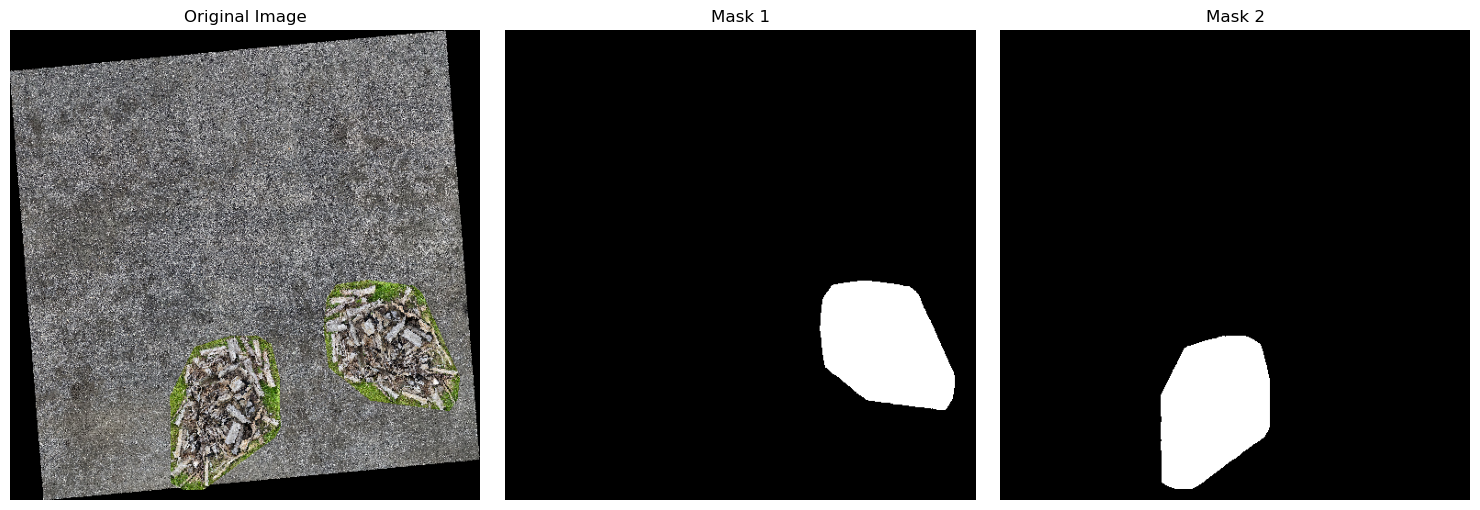

In [6]:
model = LangSAM()

orthoimage_pil = Image.fromarray(orthoimage)

# text_prompt = "cow"

text_prompt = "wood pile"
# text_prompt = "wood pile from above"
# text_prompt = "wood pile, tree stump, tree trunck"

# text_prompt = "background"
# text_prompt = "tire"
# text_prompt = "person, human, people"

# text_prompt = "truck from above"


masks, boxes, phrases, logits = model.predict(orthoimage_pil, text_prompt)

# Convert masks to numpy arrays
masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

# Display the original image and masks side by side
display_image_with_masks(orthoimage, masks_np)

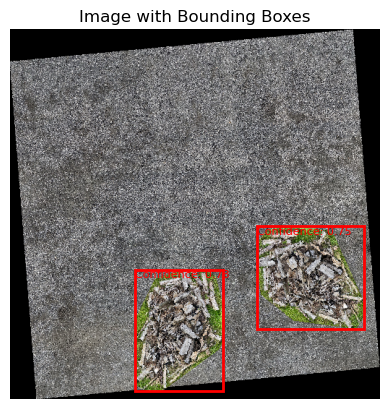

In [7]:
display_image_with_boxes(orthoimage, boxes, logits)

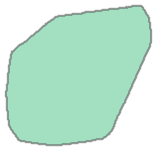

In [8]:
from shapely.geometry import Polygon, Point

mask_np = masks[0].squeeze().cpu().numpy()

mask_uint8 = np.uint8(mask_np * 255)

# Find contours in the mask
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
polygon_points = [tuple(point[0]) for point in largest_contour]
polygon = Polygon(polygon_points)

polygon


In [9]:
import torch

def crop_point_cloud(point_cloud, mapping, masks):
    polygons = []
    for mask in masks:
        # Convert the PyTorch tensor to a numpy array
        if isinstance(mask, torch.Tensor):
            mask_np = mask.cpu().numpy()  # Ensure it's moved to CPU memory
        else:
            mask_np = mask
        
        # Ensure the mask is binary and find contours
        mask_binary = mask_np.astype(np.uint8)  # Convert to uint8
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            # Convert contour points to a suitable format for Polygon
            contour_points = contour.squeeze().tolist()
            if len(contour_points) > 2:  # Polygon needs at least 3 points
                polygons.append(Polygon(contour_points))

    h, w = mapping.shape[:2]
    points_inside = []

    # Iterate over the image
    for iy in range(h):
        for ix in range(w):
            point_index = mapping[iy, ix]
            if point_index != -1:
                # Map the 2D image coordinate to a 2D point (assuming XY plane)
                point_2d = Point(ix, iy)
                # Check if the 2D point is inside any of the polygons
                if any(polygon.contains(point_2d) for polygon in polygons):
                    points_inside.append(point_index)

    # Crop the point cloud to only include points inside the polygons
    cropped_point_cloud = point_cloud[points_inside]

    return cropped_point_cloud


p = crop_point_cloud(pcd_np, mapping, masks)

In [10]:

pcd_crop_points = p[:, :3]
pcd_crop_colors = p[:, 3:]

if pcd_crop_colors.max() > 1:
    pcd_crop_colors = pcd_crop_colors / 255.0

crop_pcd = o3d.geometry.PointCloud()
crop_pcd.points = o3d.utility.Vector3dVector(pcd_crop_points)
crop_pcd.colors = o3d.utility.Vector3dVector(pcd_crop_colors)

o3d.visualization.draw_geometries([crop_pcd])
